In [16]:
from sklearn.neighbors import NearestNeighbors
import statsmodels.formula.api as smf
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

pd.options.display.float_format = "{:,.2f}".format

# Problem set 2: Regession and matching estimators in causal effects

*In this problem set we are going to compare the consistency of regression and matching estimators of causal effects based on Dehejia & Wahba (1999). For that we employ the experimental study from LaLonde (1986), which provides an opportunity to estimate true treatment effects. We then use these results to evaluate the performance of (treatment effect) estimators one can usuallly obtain in observational studies.*

*LaLonde (1986) implements the data from the National Supported Work program (NSW) -- temporary employment program designed to help disadvantaged workers lacking basic job skills move into the labor market by giving them work experience and counseling in sheltered environment. Unlike other federally sponsored employment programs, the NSW
program assigned qualiffed applications randomly. Those assigned to the treatment group received all the benets of the NSW program, while those assigned to the control group were left to fend for themselves.*

*To produce the observational study, we select the sample from the Current Population Survey (CPS) as the comparison group and merge it with the treatment group. We do this to obtain a data set which resembles the data which is commonly used in scientific practice. The two data sets are explained below:*

*- **nsw_dehejia.csv** is field-experiment data from the NSW. It contains variables as education, age, ethnicity, marital status, preintervention (1975) and postintervention (1978) earnings of the eligible male applicants. Dehejia & Wahba (1999) also transform the LaLonde (1986) data set to have observations on preintervention 1974 earnings; motivation is explained in their paper.*

*- **cps.csv** is a non-experimental sample from the CPS which selects all males under age 55 and contains the same range of variables.*

## Task A

*Create the table with the sample means of characteristics by age, education, preintervention earnings, etc. for treated and control groups of NSW sample (you can use the Table 1 from  Dehejia and Wahba (1999) as a benchmark). Is the distribution of preintervention variables similar across the treatment and control groups? Check the differences on significance. Add to the table the CPS sample means. Is the comparison group different from the treatment group in terms of age, marital status, ethnicity, and preintervention earnings?*

In [25]:
demographics = ["age", "ed", "black", "hisp", "married", "nodeg", "age2"]

dtypes = dict()
for column in ["treat"] + demographics:
    dtypes[column] = np.int

df_nsw = pd.read_csv("data/nsw_dehejia.csv", dtype=dtypes)
df_nsw.index.name = "individual"
df_nsw.head()

,treat,age,ed,black,hisp,married,nodeg,re74,re75,re78,age2
individual,,,,,,,,,,,
0,1,37,11,1,0,1,1,0.00,0.00,"9,930.05",1369
1,1,22,9,0,1,0,1,0.00,0.00,"3,595.89",484
2,1,30,12,1,0,0,0,0.00,0.00,"24,909.45",900
3,1,27,11,1,0,0,1,0.00,0.00,"7,506.15",729
4,1,33,8,1,0,0,1,0.00,0.00,289.79,1089


How does a summary of the data look like?

In [26]:
df_nsw.describe()

,treat,age,ed,black,hisp,married,nodeg,re74,re75,re78,age2
count,445.00,445.00,445.00,445.00,445.00,445.00,445.00,445.00,445.00,445.00,445.00
mean,0.42,25.37,10.20,0.83,0.09,0.17,0.78,"2,102.27","1,377.14","5,300.76",693.98
std,0.49,7.10,1.79,0.37,0.28,0.37,0.41,"5,363.58","3,150.96","6,631.49",429.78
min,0.00,17.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,289.00
25%,0.00,20.00,9.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,400.00
50%,0.00,24.00,10.00,1.00,0.00,0.00,1.00,0.00,0.00,"3,701.81",576.00
75%,1.00,28.00,11.00,1.00,0.00,0.00,1.00,824.39,"1,220.84","8,124.72",784.00
max,1.00,55.00,16.00,1.00,1.00,1.00,1.00,"39,570.68","25,142.24","60,307.93","3,025.00"


Let's look at the mean differences by treatment status.

In [27]:
df_nsw.groupby("treat").mean()

,age,ed,black,hisp,married,nodeg,re74,re75,re78,age2
treat,,,,,,,,,,
0,25.05,10.09,0.83,0.11,0.15,0.83,"2,107.03","1,266.91","4,554.80",677.32
1,25.82,10.35,0.84,0.06,0.19,0.71,"2,095.57","1,532.06","6,349.14",717.39


Are these differences statistically significant?

In [7]:
for column in demographics:

    treated = df_nsw.query("treat == 1")[column]
    control = df_nsw.query("treat == 0")[column]

    stat = ttest_ind(treated, control)[1]

    print(f"{column:<7}     {stat:7.3f}")

age           0.265
ed            0.135
black         0.649
hisp          0.076
married       0.327
nodeg         0.001
age2          0.333


In [8]:
df_cps = pd.read_csv("data/cps.csv", dtype=dtypes)
df_cps.index.name = "individual"
df_cps.head()

,treat,age,ed,black,hisp,married,nodeg,re74,re75,re78,age2
individual,,,,,,,,,,,
0,0,45,11,0,0,1,1,"21,516.67","25,243.55","25,564.67",2025
1,0,21,14,0,0,0,0,"3,175.97","5,852.56","13,496.08",441
2,0,38,12,0,0,1,0,"23,039.02","25,130.76","25,564.67",1444
3,0,48,6,0,0,1,1,"24,994.37","25,243.55","25,564.67",2304
4,0,18,8,0,0,1,1,"1,669.30","10,727.61","9,860.87",324


How does a summary of the data look like?

In [9]:
df_nsw.describe()

,treat,age,ed,black,hisp,married,nodeg,re74,re75,re78,age2
count,445.00,445.00,445.00,445.00,445.00,445.00,445.00,445.00,445.00,445.00,445.00
mean,0.42,25.37,10.20,0.83,0.09,0.17,0.78,"2,102.27","1,377.14","5,300.76",693.98
std,0.49,7.10,1.79,0.37,0.28,0.37,0.41,"5,363.58","3,150.96","6,631.49",429.78
min,0.00,17.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,289.00
25%,0.00,20.00,9.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,400.00
50%,0.00,24.00,10.00,1.00,0.00,0.00,1.00,0.00,0.00,"3,701.81",576.00
75%,1.00,28.00,11.00,1.00,0.00,0.00,1.00,824.39,"1,220.84","8,124.72",784.00
max,1.00,55.00,16.00,1.00,1.00,1.00,1.00,"39,570.68","25,142.24","60,307.93","3,025.00"


Let's compare mean differences between the synthetic control group and the treatment group.

In [10]:
for column in demographics:

    treated = df_nsw.query("treat == 1")[column]
    control = df_cps[column]

    stat = ttest_ind(treated, control)[1]

    print(f"{column:<7}     {stat:7.3f}")

age           0.000
ed            0.000
black         0.000
hisp          0.510
married       0.000
nodeg         0.000
age2          0.000


## Task B. Regression Adjustment

*In this section we compare the results of regression estimates with selection on observables as discussed in the lecture 6.*

### Task B.1

*Merge the treatment group data from the NSW sample with the comparison group data from the CPS sample to imitate an observational study.*

In [11]:
df_nsw["sample"] = "NSW"
df_cps["sample"] = "CPS"

df_obs = pd.concat([df_nsw.query("treat == 1"), df_cps])
df_obs.set_index(["sample"], append=True, inplace=True)
df_obs.sort_index(inplace=True)

df_obs.loc[(slice(1, 5), "NSW"), :]

,,treat,age,ed,black,hisp,married,nodeg,re74,re75,re78,age2
individual,sample,,,,,,,,,,,
1,NSW,1,22,9,0,1,0,1,0.00,0.00,"3,595.89",484
2,NSW,1,30,12,1,0,0,0,0.00,0.00,"24,909.45",900
3,NSW,1,27,11,1,0,0,1,0.00,0.00,"7,506.15",729
4,NSW,1,33,8,1,0,0,1,0.00,0.00,289.79,1089
5,NSW,1,22,9,1,0,0,1,0.00,0.00,"4,056.49",484


### Task B.2

*Which assumption need to hold such that conditioning on observables can help in obtaining an unbiased estimate of the true treatment effect?*

$$E[Y^1|D = 1, S] = E[Y^1|D = 0, S]$$
$$E[Y^0|D = 1, S] = E[Y^0|D = 0, S]$$

### Task B.3

*Run a regression on both experimental and non-experimental data using the specification: RE78 on a constant, a treatment indicator, age, age2, education, marital status, no degree, black, hispanic, RE74, and RE75. We recommend using statsmodels, but you are free to use any other software. Is the treatment effect estimate of the observational study consistent with the true estimate?*

We first construct the regression equation.

In [11]:
indep_vars = df_obs.columns.tolist()
indep_vars.remove("re78")

formula = "re78 ~ " + " " " + ".join(indep_vars)

Now we can run the model on both datasets.

In [12]:
for label, data in [("observational", df_obs), ("experimental", df_nsw)]:
    stat = smf.ols(formula=formula, data=data).fit().params["treat"]
    print(f"Estimate based on {label} data: {stat:7.3f}")

Estimate based on observational data: 793.587
Estimate based on experimental data: 1675.862


## Task C. Matching on Propensity Score

*Recall that the propensity score p(Si) is the probability of unit i having been assigned to treatment. Most commonly this function is modeled to be dependent on various covariates. We write $p(S_i) := Pr(D_i = 1|S_i) = E(D_i|S_i).$ One assumption that makes estimation strategies feasible is $S_i \perp D_i|p(S_i)$ which means that, conditional on the propensity score, the covariates are independent of assignment to treatment. Therefore, conditioning on the propensity score, each individual has the same probability of assignment to treatment,
as in a randomized experiment.*

*Estimation is done in two steps. First, we estimate the propensity score using a logistic regression model. Secondly, we match the observations on propensity score employing nearest-neighbor algorithm discussed in the lecture 5. That is, each treatment unit is matched to the comparison unit with the closest propensity score -- the unmatched comparison units are discarded.*

### Task C.1

*Before we start with matching on propensity score, let's come back to another matching strategy which was discussed in Lecture 5 - matching on stratification. Looking at the data could you name at least two potential reasons why matching on stratification might be impossible to use here?*

Data contains continuous variables; formed stratas might not have treated and control units available at the same time.

### Task C.2

*Employing our imitated observational data run a logistic regression on the following specification: treatment indicator on age, education, marital status, no degree, black, hispanic, RE74, and RE75. Use, for example, \texttt{statsmodels} for this task. Then extract a propensity score for every individual as a probability to be assigned into treatment.*

In [13]:
formula = "treat ~ age + ed + black + hisp + married + nodeg + re74 + re75"
df_obs["pscore"] = smf.logit(formula=formula, data=df_obs).fit().predict()

Optimization terminated successfully.
         Current function value: 0.031035
         Iterations 12


### Task C.3

*Before proceeding further we have to be sure that propensity scores of treatment units overlap with the propensity scores of control units. Draw a figure  showing the distribution of propensity score across treatment and control units (we use the packages matplotlib and seaborn). Do we observe common support?*

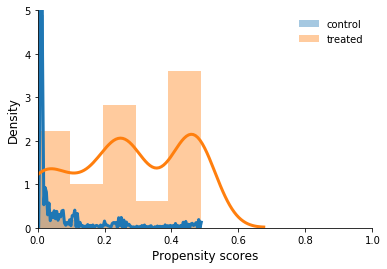

In [14]:
fig, ax = plt.subplots()

for treat, label in enumerate(["control", "treated"]):
    sns.distplot(
        df_obs.query(f"treat == {treat}")["pscore"], ax=ax, label=label
    )

ax.set_ylim(0, 5)
ax.set_xlim(0, 1)
ax.set_ylabel("Density")
ax.set_xlabel("Propensity scores")
ax.legend()

### Task C.4

*Match each treatment unit with control unit one-to-one with replacement. We use the package sklearn.neighbors: apply the algorithm NearestNeighbors to the propensity score of treated and control units and extract the indices of matched control units.*

In [15]:
def get_matched_dataset(df):
    training_data = df.query("treat == 0")["pscore"].to_numpy().reshape(-1, 1)
    eval_point = df.query("treat == 1")["pscore"].to_numpy().reshape(-1, 1)

    neigh = NearestNeighbors(n_neighbors=1)

    neigh.fit(training_data)
    matched = neigh.kneighbors(eval_point, return_distance=False)[:, 0]

    df_treated = df.query("treat == 1")
    df_matched = df.query("treat == 0").iloc[matched]

    df_sample = pd.concat([df_treated, df_matched])

    return df_sample

### Task C.5

*Construct new data set with matched observations. Run the regression to obtain matching on propensity score estimate. Is it more or less consistent estimate of the true effect comparing to the regression estimate with selection on observables? How could you explain this result?*

In [16]:
df_sample = get_matched_dataset(df_obs)
stat = smf.ols(formula="re78 ~ treat", data=df_sample).fit().params["treat"]
print(f"Estimate based on matched for re78 data: {stat:7.3f}")

Estimate based on matched for re78 data: 1551.477


Regression model neglects important nonlinear terms and interactions (Rubin 1973). The benefit of matching over regression is that it is non-parametric (but you do have to assume that you have the right propensity score specification in case of  matching).

Let's further explore two selected issues in matching, i.e. the use of placebo testing and trimming.

In [17]:
stat = smf.ols(formula="re75 ~ treat", data=df_sample).fit().params["treat"]
print(f"Estimate based on matched for re75 data: {stat:7.3f}")

Estimate based on matched for re75 data: 221.917


What happens if we trim our dataset?

In [18]:
for value in [0.025, 0.05, 0.1, 0.15]:

    lower, upper = value, 1 - value
    df_trimmed = df_obs.loc[df_obs["pscore"].between(lower, upper), :]

    df_sample = get_matched_dataset(df_trimmed)

    stat = (
        smf.ols(formula="re78 ~ treat", data=df_sample).fit().params["treat"]
    )
    print(f"{value:5.3f}: {stat:7.3f}")

0.025: 1563.983
0.050: 1665.306
0.100: 1744.330
0.150: 2138.977


## References

- Bureau of Labor Statistics. (1974, 1975, 1978). [Current Population Survey](https://www.census.gov/programs-surveys/cps.html).
- Dehejia, R., and Wahba, S. (1999). [Causal effects in nonexperimental studies: Reevaluating the evaluation of training programs](https://www.jstor.org/stable/2669919?seq=1). *Journal of the American Statistical Association, 94*(448), 1053-1062.
- LaLonde, R. J. (1986). [Evaluating the econometric evaluation of training programs with experimental data](https://www.jstor.org/stable/1806062?seq=1). *American Economic Review, 76*(4), 604-620.